In [11]:
# Class to use
import sys
sys.path.append("../../python")
from auditing_setup.election_setting import Election

# Makes report plot
# improt and define basic params
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from pathlib import Path
from os import listdir, path, makedirs

mpl.rcParams["savefig.dpi"] = 200
# Calibrated data dir
calibrated_base_dir = Path("..")/"../new_calibrate_full/"
calibration_curve_base_dir = Path("..")/"../calibration_curve/"
calibrated_table_dir = Path("..")/"../tables/"
uncalibrated_table_dir = Path("..")/"../uncalibrated_tables/"

from matplotlib import pyplot as plt
from matplotlib import rc
import seaborn as sns
import matplotlib as mpl
plt.rc('font', family='serif', serif='Times')
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
sns.set(style="darkgrid", font_scale=2)
sns.set_context('paper', font_scale=1.5)

def toggle_tex(to=None):
    if to is not None:
        rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
        rc('text', usetex=to)
    elif mpl.rcParams['text.usetex']:
        rc('text', usetex=False)
    else:
        rc('text', usetex=True)
mpl.rcParams["savefig.dpi"] = 200
        
toggle_tex(to=False)
%matplotlib inline

In [12]:
legend_order = ['bravo    | p=0.7 ',
                'bravo    | p=0.55 ',
                'bravo    | p=0.52 ',
                'bravo    | p=0.51 ',
                'bravo_without_replacement | p=0.7 ',
                'bravo_without_replacement | p=0.55 ',
                'bravo_without_replacement | p=0.52 ',
                'bravo_without_replacement | p=0.51 ',
                'bayesian | a=1 | b=1 ',
                'bayesian_with_replacement | a=1 | b=1 ',
                'truncated_bayesian | a=1 | b=1 ',
                'clip     ', 
                'max_sprt ']

def get_position(name):
    for i, legend_pattern in enumerate(legend_order):
        if name.lower().startswith(legend_pattern):
            return i
    else:
        print(name)
        assert False

def reorder_df(df):
    return df.loc[sorted(df.index, key=get_position)]

mpl.rcParams["figure.figsize"] = [8, 6]

def read_csv(file_path, reorder=True):
    df = pd.read_csv(file_path)
    cols = []
    for i in df.columns:
        try:
            cols.append(float(i))
        except Exception as e:
            cols.append(i)
    df.columns = cols
    df.set_index('legend', inplace=True)
    if reorder:
        df = reorder_df(df)
    return df.reset_index()

def get_num_cols(df):
    cols = []
    for i in df.columns:
        try:
            float(i)
            cols.append(float(i))
        except Exception as e:
            pass
    return cols

def format_legend(ax=None, legend=None, how=0):
    if ax is not None:
        legend_ = ax.legend_
    elif legend is not None:
        legend_ = legend
    else:
        return
    
    for text in legend_.texts:
        if how == 0:
            raw = text.get_text()
            text.set_text(raw.replace(" | ", ", ").replace(" ", "").rsplit(",", 1)[0])
        elif how == 1:
            raw = text.get_text()
            print(raw.rsplit(",", 1)[0].replace("_", " "))
            text.set_text(raw.rsplit(",", 1)[0].replace("_", " "))
    return legend_

def make_legend(df, ax, outside=False, *args, **kwargs):
    if outside:
        ax.legend(labels=[basename+" "+parameter for i, (basename, parameter) in 
                          df[['basename_with_type', 'parameter']].drop_duplicates()
                          .iterrows()],
                 bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                 *args, **kwargs)
    else:
        ax.legend(labels=[basename+" "+parameter for i, (basename, parameter) in 
                          df[['basename_with_type', 'parameter']].drop_duplicates()
                          .iterrows()], *args, **kwargs)

In [13]:
cols = sns.color_palette("bright", 6)
cs_dict = {'bayesian | a=1 | b=1':cols[0],
           'bayesian_with_replacement | a=1 | b=1':cols[0],
           'bravo    | p=0.55':cols[1],
           'bravo    | p=0.7':cols[1],
           'bravo_without_replacement | p=0.55':cols[2],
           'bravo_without_replacement | p=0.7':cols[2],
           'clip    ':cols[3], 
           'max_sprt':cols[4],
           'truncated_bayesian | a=1 | b=1':cols[5]}

# ls_dict = {'bayesian | a=1 | b=1':'-',
#            'bayesian_with_replacement | a=1 | b=1':'--',
#            'bravo    | p=0.55':'-',
#            'bravo    | p=0.7':'--',
#            'bravo_without_replacement | p=0.55':'-',
#            'bravo_without_replacement | p=0.7':'--',
#            'clip    ':'--', 
#            'max_sprt':'--',
#            'truncated_bayesian | a=1 | b=1':'--'}
ls_dict = {'bayesian | a=1 | b=1':'-',
           'bayesian_with_replacement | a=1 | b=1':'-',
           'bravo    | p=0.55':'-',
           'bravo    | p=0.7':'-',
           'bravo_without_replacement | p=0.55':'-',
           'bravo_without_replacement | p=0.7':'-',
           'clip    ':'-', 
           'max_sprt':'-',
           'truncated_bayesian | a=1 | b=1':'-'}

ms_dict = {'bayesian | a=1 | b=1':'o',
           'bayesian_with_replacement | a=1 | b=1':'s',
           'bravo    | p=0.55':'<',
           'bravo    | p=0.7':'>',
           'bravo_without_replacement | p=0.55':'P',
           'bravo_without_replacement | p=0.7':'X',
           'clip    ':'o', 
           'max_sprt':'o',
           'truncated_bayesian | a=1 | b=1':'o'}

In [14]:
def map_styles(legends):
    cs, ls, ms = [], [], []
    for legend in legends:
        legend = legend.rsplit(" | ", 1)[0]
        ls.append(ls_dict[legend])
        cs.append(cs_dict[legend])
        ms.append(ms_dict[legend])
    return cs, ls, ms

In [15]:
def pivot_widetable(df, names, groupers, *args, **kwargs):
    df_long = df.melt(*args, **kwargs)
    for name, grouper in zip(names, groupers):
        group = [grouper(i) for i in df_long['variable']]
        df_long[name] = group
    return df_long

names = [
    'type'
    'basename'
    'basename_with_type'
    'parameter'
    'parameter_with_type'
]

basename_map = {'bayesian ': 'Bayesian',
                'max_sprt ': 'MaxBRAVO',
                'bravo    ': 'BRAVO',
                'clip     ': 'ClipAudit',
                'bravo_without_replacement ': 'BRAVO',
                'truncated_bayesian ': 'MartInf',
                'bayesian_with_replacement ': 'Bayesian'}

type_map = {'bayesian ': 'BetaBinomial',
            'max_sprt ': '',
            'bravo    ': 'Binomial',
            'clip     ': '',
            'bravo_without_replacement ': 'Hypergeometric',
            'truncated_bayesian ': '',
            'bayesian_with_replacement ': 'Beta'}

basename_map_with_type = {'bayesian ': 'Bayesian (BetaBinomial)',
                          'max_sprt ': 'MaxBRAVO',
                          'bravo    ': 'BRAVO (Binomial)',
                          'clip     ': 'ClipAudit',
                          'bravo_without_replacement ': 'BRAVO (Hypergeometric)',
                          'truncated_bayesian ': 'MartInf',
                          'bayesian_with_replacement ': 'Bayesian (Beta)'}

def group_basename(name):
    name = name.split('|')[0]
    return basename_map[name]

def group_type(name):
    name = name.split('|')[0]
    return type_map[name]

def group_basename_with_type(name):
    name = name.split('|')[0]
    return basename_map_with_type[name]

def group_parameter(name):
    _, name = name.split('|', 1)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return name

def group_parameter_with_type(name):
    _, name = name.split('|', 1)
    type = group_type(_)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return type+' '+name
    
groupers = [
    group_type,
    group_basename,
    group_basename_with_type,
    group_parameter,
    group_parameter_with_type
]

filled_markers = (
    'o', 'v', '^', 
    
    '<', '>', '*', 
    
    's', '8', 
    
    'H', 
    
    'D', 
    
    'X')
dash_styles = [
    "",
    (4, 1.5),
    (1, 1),
    
    "",
    (4, 1.5),
    (1, 1),
    
    "",
    (5, 1, 1, 1),
    
    (2, 2, 3, 1.5),
    (1, 2.5, 3, 1.2),
    (5, 1, 2, 1, 2, 1),
]

In [16]:
def prep_long_df(df):
    if 'legend' not in df.columns:
        df = df.reset_index()
    data_long = pivot_widetable(df, [], [], id_vars='legend', var_name='p', value_name='expected_sample')
    types = data_long.legend.apply(group_type)
    basenames = data_long.legend.apply(group_basename)
    parameters = data_long.legend.apply(group_parameter)
    basenames_with_type = data_long.legend.apply(group_basename_with_type)
    parameters_with_type = data_long.legend.apply(group_parameter_with_type)
    data_long['type'] = types
    data_long['basename'] = basenames
    data_long['basename_with_type'] = basenames_with_type
    data_long['parameter'] = parameters
    data_long['parameter_with_type'] = parameters_with_type
    return data_long

In [37]:
n * 0.1 * (1-power_long['expected_sample'])

,legend,p,type,basename,basename_with_type,parameter,parameter_with_type,variable,value
0,bravo_without_replacement | p=0.55 | alpha=0.0...,0.45,Hypergeometric,BRAVO,BRAVO (Hypergeometric),p=0.55,Hypergeometric p=0.55,1,21997.260940
1,bayesian | a=1 | b=1 | critical_value=0.002441...,0.45,BetaBinomial,Bayesian,Bayesian (BetaBinomial),"a=1,b=1","BetaBinomial a=1,b=1",1,21887.940598
2,bravo_without_replacement | p=0.55 | alpha=0.0...,0.48,Hypergeometric,BRAVO,BRAVO (Hypergeometric),p=0.55,Hypergeometric p=0.55,1,21899.727142
3,bayesian | a=1 | b=1 | critical_value=0.002441...,0.48,BetaBinomial,Bayesian,Bayesian (BetaBinomial),"a=1,b=1","BetaBinomial a=1,b=1",1,21682.146533
4,bravo_without_replacement | p=0.55 | alpha=0.0...,0.5,Hypergeometric,BRAVO,BRAVO (Hypergeometric),p=0.55,Hypergeometric p=0.55,1,20934.144533
5,bayesian | a=1 | b=1 | critical_value=0.002441...,0.5,BetaBinomial,Bayesian,Bayesian (BetaBinomial),"a=1,b=1","BetaBinomial a=1,b=1",1,20937.135957
6,bravo_without_replacement | p=0.55 | alpha=0.0...,0.51,Hypergeometric,BRAVO,BRAVO (Hypergeometric),p=0.55,Hypergeometric p=0.55,1,18796.013084
7,bayesian | a=1 | b=1 | critical_value=0.002441...,0.51,BetaBinomial,Bayesian,Bayesian (BetaBinomial),"a=1,b=1","BetaBinomial a=1,b=1",1,19170.107896
8,bravo_without_replacement | p=0.55 | alpha=0.0...,0.52,Hypergeometric,BRAVO,BRAVO (Hypergeometric),p=0.55,Hypergeometric p=0.55,1,14079.451337
9,bayesian | a=1 | b=1 | critical_value=0.002441...,0.52,BetaBinomial,Bayesian,Bayesian (BetaBinomial),"a=1,b=1","BetaBinomial a=1,b=1",1,14623.780527


/Users/Dovermore/.conda/envs/audit_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


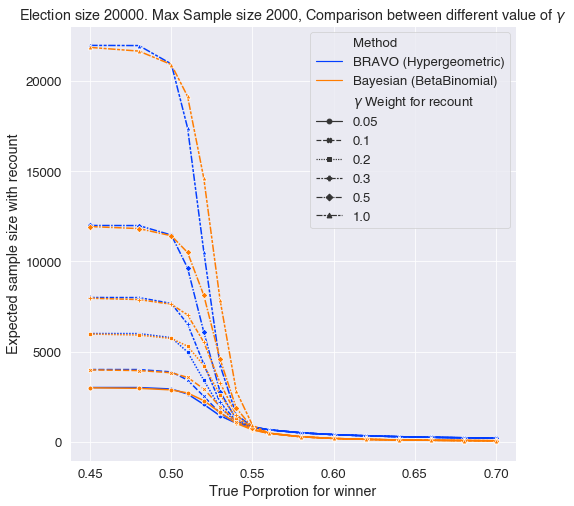

In [67]:
# 1. Basic 20000/2000 plot without replacement

n = 20000
m = 2000
# gammas = np.array([0.05, 0.1, 0.2, 0.3])
gammas = np.array([1, 0.5, 0.3, 0.2, 0.1, 0.05])
# gammas = np.array([1])
# gammas = np.array([0.1])

election = Election(n, m, 0.5, 1, False)

query = 'basename_with_type == "BRAVO (Hypergeometric)" and (parameter == "p=0.51") or basename_with_type == "Bayesian (BetaBinomial)"'
# query = 'basename_with_type == "Bayesian (BetaBinomial)"'
# query = 'basename_with_type != None'

data_type = "power.csv"
data_path = calibrated_table_dir/str(election)/data_type
power_long = prep_long_df(read_csv(data_path)).query(query)

data_type = "unconditional_mean.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path)).query(query)

for gamma in gammas:
    data_long[gamma] = n * gamma * (1-power_long['expected_sample']) + data_long['expected_sample']

data_long.drop('expected_sample', inplace=True, axis=1)
data_long = data_long.melt(id_vars=[i for i in data_long.columns if i not in gammas], value_vars=gammas)

# data
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(111)
ax.set_title("Election size 20000. Max Sample size 2000, Comparison between different value of $\gamma$")
sns.lineplot(
    x = 'p',
    y = 'value',
    hue = 'basename_with_type',
    style= 'variable',
    data=data_long,
    markers=True, 
    palette='bright', 
    legend='full',
    ax=ax, lw=1.5)

ax.legend_.texts[0].set_text('Method')
ax.legend_.texts[3].set_text('$\gamma$ Weight for recount')

ax.set_xlabel("True Porprotion for winner")
ax.set_ylabel("Expected sample size with recount")

fig.savefig('../../figures/recount_weight.png')

# Calibration curve

In [ ]:
# Calibration Curve
# 1. Basic 5000/500 plot without replacement
# data
election = Election(10000, 1000, 0.5, 1, False)
data_path = calibration_curve_base_dir/str(election)

xs = []
ys = []
labels = []
for method_data in data_path.iterdir():
    method, param, _ = method_data.stem.rsplit("_", 2)
    param = param.split("=")[0]
    data_df = pd.read_csv(method_data)
    data_df.columns = [param, method]
    data_df.set_index(param, inplace=True)
    xs += list(data_df.index)
    ys += list(data_df[method])
    labels += [method] * len(data_df.index)
    
data = pd.DataFrame(data = dict(
    xs = xs,
    ys = ys,
    legend = labels
))

legend_order_pair = [
    ('bravo_p=0.7', ('BRAVO (Binomial)', 'p=0.7')),
    ('bravo_p=0.55', ('BRAVO (Binomial)', 'p=0.55')),
    ('bravo_without_replacement_p=0.7', ('BRAVO (Hypergeometric)', 'p=0.7')),
    ('bravo_without_replacement_p=0.55', ('BRAVO (Hypergeometric)', 'p=0.55')), 
    ('bayesian_with_replacement_a=1_b=1_critical', ('Bayesian', '(BetaBinomial) a=1, b=1')), 
    ('bayesian_a=1_b=1_critical', ('Bayesian', '(Beta) a=1, b=1')), 
    ('truncated_bayesian_a=1_b=1_critical', ('MartInf', 'a=1, b=1')),
    ('clip', ('Clip', '')), 
    ('max_sprt', ('MaxBRAVO', '')),
]
legend_order_dict = dict(legend_order_pair)

def get_position(name):
    for i, (legend_pattern, (_, _)) in enumerate(legend_order_pair):
        if name.lower().startswith(legend_pattern):
            return i
    else:
        assert False

def reorder_df2(df):
    df.set_index('legend', inplace=True)
    return df.loc[sorted(df.index, key=get_position)].reset_index()

data = reorder_df2(data)
data['basename'] = [legend_order_dict[i][0] for i in data['legend']]
data['parameter'] = [legend_order_dict[i][1] for i in data['legend']]

In [ ]:
fig = plt.figure(figsize=[6,6])

ax = fig.add_subplot(111)
sns.lineplot(x='xs', 
             y='ys', 
             hue='basename', 
             style='parameter', 
             size='parameter', 
             data=data, 
             markers=False, 
             dashes=dash_styles,
             palette='bright', 
             legend=False, 
             sizes=(1, 3),
             ax=ax)
plt.legend([i[1][0] + ' ' + i[1][1] for i in legend_order_pair])
plt.xlabel('Critical value $h$')
plt.ylabel('Risk')
plt.title('Calibration Curve of different methods')
plt.tight_layout()
plt.savefig('../../figures/calibration_10000.png')